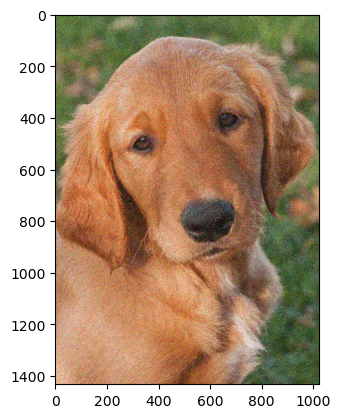

In [1]:
import numpy as np
from skimage import io
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.transform import resize

img = io.imread ("/Users/jiyoung/Desktop/univ/'23-2/Engineering Design/workspace/dog.jpeg")
img = img[:,:,:3] # remove alpha channel
img = img/255.0
image = img

from skimage.util import random_noise
# Step 1: Add salt and pepper noise
salt_pepper_image = random_noise(img, mode='s&p', amount=0.1)
#plt.imsave('salt_pepper_image.png', salt_pepper_image)

# Step 2: Add additive white Gaussian noise
mean = 0
var = 0.01
std = np.sqrt(var)
gaussian_noise = np.random.normal(mean, std, salt_pepper_image.shape)
noisy_image = salt_pepper_image + gaussian_noise

noisy_image = np.clip(noisy_image, 0., 1.0)

# Clip the pixel values to be in the [0, 1] range
noisy_image = np.clip(noisy_image, 0., 1.0)
#plt.imsave('noisy_image.png', noisy_image)
plt.imshow(noisy_image)

In [2]:
print("**원본 이미지, 원본 psnr 비교**")
print("PSNR :", peak_signal_noise_ratio(img, image))

print("**원본 이미지, s&p image psnr 비교**")
print("PSNR :", peak_signal_noise_ratio(img, salt_pepper_image))
          
print("**원본 이미지, s&p noise image + WG noise image 비교**")
print("PSNR :", peak_signal_noise_ratio(img, noisy_image))

**원본 이미지, 원본 psnr 비교**
PSNR : inf
**원본 이미지, s&p image psnr 비교**
PSNR : 15.267474939275719
**원본 이미지, s&p noise image + WG noise image 비교**
PSNR : 14.566224248020323


/Users/jiyoung/Downloads/yes/envs/3.8/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


ValueError: Input images must have the same dimensions.

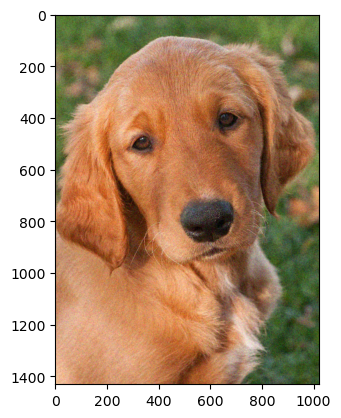

In [3]:
# Median Filter
def median_filter(img, filter_size=(3, 3), stride=1):
    img_shape = np.shape(img)
    result_shape = tuple(np.int64((np.array(img_shape[:2]) - np.array(filter_size)) / stride) + 1) + (img_shape[2],)
    result = np.zeros(result_shape)

    for h in range(0, result_shape[0], stride):
        for w in range(0, result_shape[1], stride):
            for c in range(img_shape[2]):
                tmp = img[h:h + filter_size[0], w:w + filter_size[1], c].ravel()
                tmp = np.sort(tmp)
                result[h, w, c] = tmp[int(len(tmp) / 2)]

    return result[:img_shape[0], :img_shape[1], :]

noisy_image = np.clip(noisy_image, 0., 1.0)

filtered_channels = []
for i in range(noisy_image.shape[2]):  # Exclude the last channel (alpha channel)
    filtered_channel = median_filter(noisy_image[:, :, i:i+1], filter_size=(3, 3), stride=1)
    filtered_channels.append(filtered_channel)

median_filtered_image = np.concatenate(filtered_channels, axis=2)
median_filtered_image = np.clip(median_filtered_image, 0., 1.0)

plt.imshow(median_filtered_image)
print("PSNR(med):", peak_signal_noise_ratio(img, median_filtered_image))


PSNR (Median): 24.34847530202303


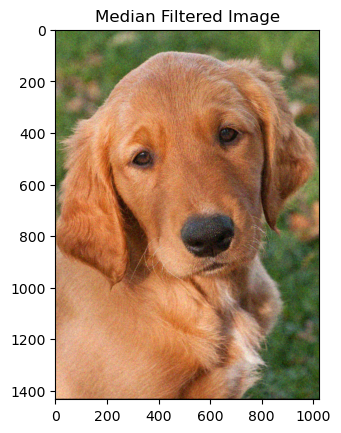

In [ ]:
# red_channel = noisy_image[:, :, 0]
# green_channel = noisy_image[:, :, 1]
# blue_channel = noisy_image[:, :, 2]

# red_channel_filtered = np.zeros_like(red_channel)
# green_channel_filtered = np.zeros_like(green_channel)
# blue_channel_filtered = np.zeros_like(blue_channel)

# for i in range(1, red_channel.shape[0] - 1):
#     for j in range(1, red_channel.shape[1] - 1):

#         r = np.sort(red_channel[i-1:i+2, j-1:j+2].ravel())
#         g = np.sort(green_channel[i-1:i+2, j-1:j+2].ravel())
#         b = np.sort(blue_channel[i-1:i+2, j-1:j+2].ravel())

#         red_channel_filtered[i, j] = r[4]
#         green_channel_filtered[i, j] = g[4]
#         blue_channel_filtered[i, j] = b[4]

# filtered_image = np.stack([red_channel_filtered, green_channel_filtered, blue_channel_filtered], axis=-1)

# filtered_image = np.clip(filtered_image, 0., 1.0)
# plt.title("Median Filtered Image")
# plt.imshow(filtered_image)
# print("PSNR (Median):", peak_signal_noise_ratio(img, filtered_image))

/var/folders/n1/t3hm6b612gg69mlfjrdv4ht00000gn/T/ipykernel_77645/1350034572.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = np.zeros((rows + (2*pad_size), cols+(2*pad_size), ch), dtype=np.float)


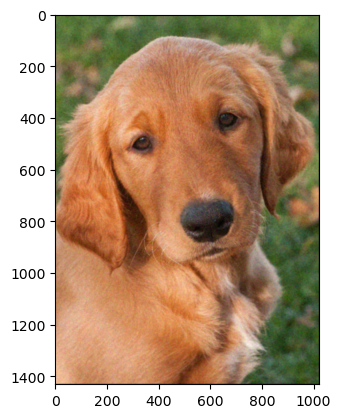

In [ ]:
# Gaussian Filter
def gaussian_kernel(k_size, sigma):
    size = k_size//2
    y, x = np.ogrid[-size:size+1, -size:size+1]
    filter = 1/(2*np.pi * (sigma**2)) * np.exp(-1 *(x**2 + y**2) /(2*(sigma**2)))
    sum = filter.sum()
    filter /= sum
    return filter

def padding(img, k_size):
    pad_size = k_size//2
    rows, cols, ch = img.shape
    res = np.zeros((rows + (2*pad_size), cols+(2*pad_size), ch), dtype=np.float)
    if pad_size == 0:
        res = img.copy()
    else:
        res[pad_size:-pad_size, pad_size:-pad_size] = img.copy()
    return res

def gaussian_filtering(img, k_size=5, sigma=4):
    rows, cols, channels = img.shape
    filter = gaussian_kernel(k_size, sigma)
    pad_img = padding(img, k_size)
    filtered_img = np.zeros((rows, cols, channels), dtype=np.float32)
    
    for ch in range(0, channels):
        for i in range(rows):
            for j in range(cols):
                filtered_img[i, j, ch] = np.sum(filter * pad_img[i:i+k_size, j:j+k_size, ch])

    return filtered_img

# Gaussian Filtered Image
gaussian_filtered_image = gaussian_filtering(noisy_image)
#plt.imsave('gaussian_filtered_image.png', gaussian_filtered_image)
plt.imshow(gaussian_filtered_image)

# Gaussian Filtered Image after Median Filtering
gaussian_filtered_image_after_median = gaussian_filtering(median_filtered_image)
plt.imsave('gaussian_filtered_image_after_median.png', gaussian_filtered_image_after_median)
plt.imshow(gaussian_filtered_image_after_median)


PSNR (Noisy): 14.565647836627981


TypeError: median_filter() got an unexpected keyword argument 'stride'

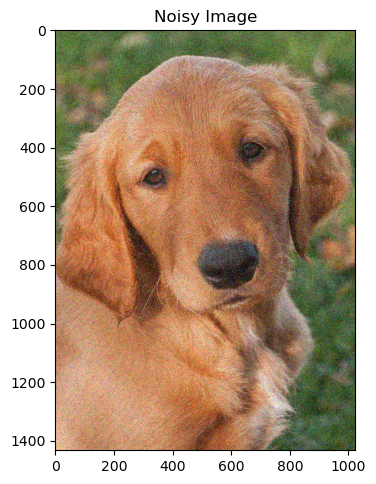

In [ ]:
from skimage.transform import resize

# Display the original, noisy, median-filtered, and Gaussian-filtered images
plt.figure(figsize=(12, 12))

# # Original Image
# plt.subplot(3, 3, 1)
# plt.title("Original Image")
# plt.imshow(img)
# print("PSNR (Original):", peak_signal_noise_ratio(img, img))

# Noisy Image
plt.subplot(2, 2, 1)
plt.title("Noisy Image")
plt.imshow(noisy_image)
print("PSNR (Noisy):", peak_signal_noise_ratio(img, noisy_image))

# Median Filtered Image
median_image = median_filter(noisy_image, filter_size=(3, 3), stride=1)
plt.subplot(2, 2, 2)
plt.title("Median Filtered Image")
plt.imshow(median_image)
print("PSNR (Median):", peak_signal_noise_ratio(img, median_image))

# Gaussian Filtered Image
gaussian_filtered_image_resized = resize(gaussian_filtered_image, noisy_image.shape[:2], mode='constant', anti_aliasing=True)
gaussian_filtered_image_resized = np.clip(gaussian_filtered_image_resized, 0., 1.0)  # Ensure values are in [0, 1] range
plt.subplot(2, 2, 3)
plt.title("Gaussian Filtered Image")
plt.imshow(gaussian_filtered_image_resized)
print("PSNR (Gaussian):", peak_signal_noise_ratio(img, gaussian_filtered_image_resized))

# Gaussian Filtered Image after Median Filtering
gaussian_filtered_image_after_median_resized = resize(gaussian_filtered_image_after_median, noisy_image.shape[:2], mode='constant', anti_aliasing=True)
gaussian_filtered_image_after_median_resized = np.clip(gaussian_filtered_image_after_median_resized, 0., 1.0)  # Ensure values are in [0, 1] range
plt.subplot(2, 2, 4)
plt.title("Gaussian Filtered Image after Median Filtering")
plt.imshow(gaussian_filtered_image_after_median_resized)
print("PSNR (Gaussian after Median):", peak_signal_noise_ratio(img, gaussian_filtered_image_after_median_resized))

plt.show()
